In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
from geopy.distance import geodesic

from IS2ML_utils import *

In [2]:
fn_features = 'sonar/sonar_segments_depth_features.parquet'
df_feat = pd.read_parquet(fn_features).reset_index(drop=True)
pred_valid = df_feat.iloc[:, 6:].copy()
step = 0.1
smooth_std = 10.0 # sentinel-2 resolution
wdw = int(np.ceil(smooth_std/step))
thisid = df_feat.IS2_id.unique()[0]
df_feat['depth_smooth'] = np.nan
for thisid in df_feat.IS2_id.unique():
    idselect = df_feat.IS2_id == thisid
    dfid = df_feat[idselect]
    xatc_interp = np.arange(0, dfid.xatc.max()+step, step)
    depth_interp = np.interp(xatc_interp, dfid.xatc, dfid.depth)
    depth_interp_smooth = pd.Series(depth_interp).rolling(window=wdw*3, center=True, min_periods=1, win_type='gaussian').mean(std=wdw)
    depth_valid = np.interp(dfid.xatc, xatc_interp, depth_interp_smooth)
    df_feat.loc[idselect, 'depth_smooth'] = depth_valid

depth_valid = df_feat.depth_smooth

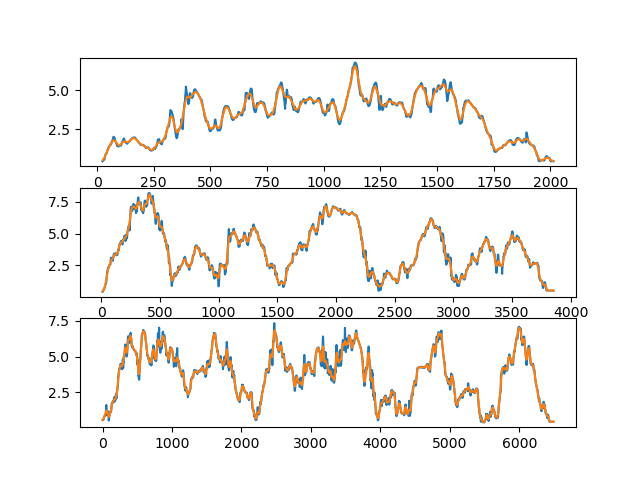

In [3]:
fig, axs = plt.subplots(nrows=3)
for iplt, thisid in enumerate(df_feat.IS2_id.unique()):
    df_f = df_feat[df_feat.IS2_id == thisid]
    ax = axs[iplt]
    ax.plot(df_f.xatc, df_f.depth)
    ax.plot(df_f.xatc, df_f.depth_smooth)

In [4]:
import pickle
from sklearn.base import BaseEstimator, RegressorMixin

class MeanEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, regressors):
        self.regressors = regressors
    
    def fit(self, X, y):
        # Assume regressors are already fitted
        pass
    
    def predict(self, X):
        # Collect predictions from all regressors
        predictions = np.column_stack([regressor.predict(X) for regressor in self.regressors])
        # Return the mean of predictions
        return np.mean(predictions, axis=1)

with open('models/ensemble_regressor_test.pkl', 'rb') as f:
    loaded_ensemble_regressor = pickle.load(f)

In [5]:
# Make predictions
depth_valid_pred = loaded_ensemble_regressor.predict(pred_valid)
# depth_valid_pred[pred_valid.ndwi < 0.1] = 0.0

mae = mean_absolute_error(depth_valid, depth_valid_pred)
mse = mean_squared_error(depth_valid, depth_valid_pred)
bias = np.nanmean(depth_valid - depth_valid_pred)
percent = np.nanmean((depth_valid - depth_valid_pred) / depth_valid) * 100
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Bias: {bias}')
over_under = 'depth overestimate' if bias < 0 else 'depth underestimate'
print(f'Percentage off: {percent} % {over_under}')

df_result_valid = df_feat.copy()
df_result_valid['depth_pred'] = depth_valid_pred

Mean Absolute Error: 0.8275482405901703
Mean Squared Error: 1.0177111380428416
Mean Bias: 0.6166426376552997
Percentage off: 15.550453830905756 % depth underestimate


In [6]:
# smoothed
# Mean Absolute Error: 0.8440094665740245
# Mean Squared Error: 1.061074298511856
# Mean Bias: 0.6193192571265332
# Percentage off: 15.337653984835633 % depth underestimate

# not smoothed
# Mean Absolute Error: 0.8572241945037479
# Mean Squared Error: 1.0970016306851413
# Mean Bias: 0.6194626822729709
# Percentage off: 14.83993717555423 % depth underestimate

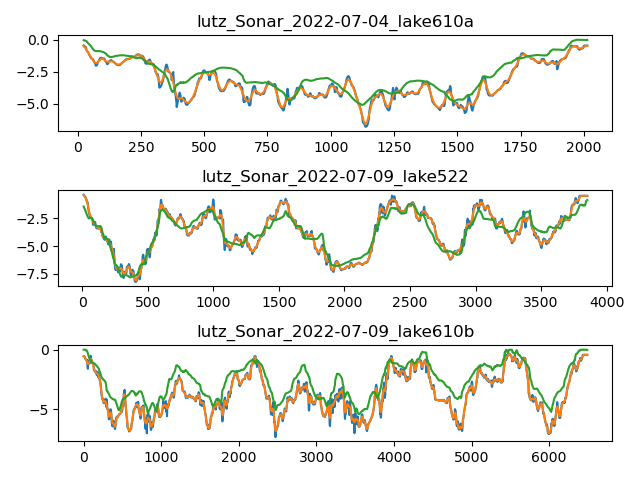

In [7]:
fig, axs = plt.subplots(nrows=3)
for iplt, thisid in enumerate(df_result_valid.IS2_id.unique()):
    df_f = df_result_valid[df_result_valid.IS2_id == thisid]
    ax = axs[iplt]
    ax.plot(df_f.xatc, -df_f.depth)
    ax.plot(df_f.xatc, -df_f.depth_smooth)
    ax.plot(df_f.xatc, -df_f.depth_pred)
    ax.set_title(thisid)
fig.tight_layout()


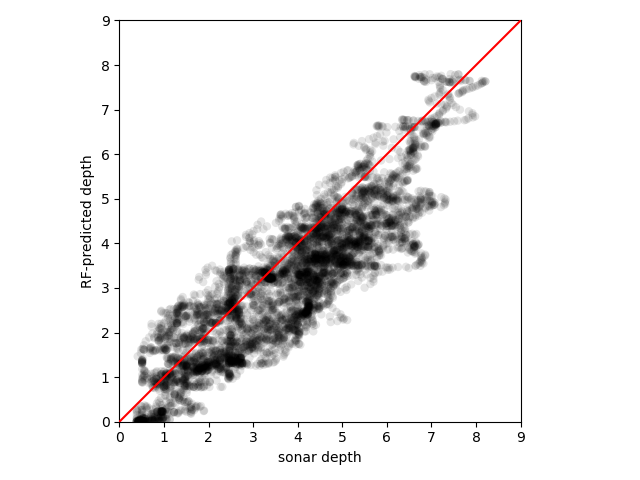

In [8]:
fig, ax = plt.subplots()
ax.scatter(df_result_valid.depth, df_result_valid.depth_pred, color='k', edgecolors='none', alpha=0.1)
ax.set_xlabel('sonar depth')
ax.set_ylabel('RF-predicted depth')
ax.set_aspect('equal')
lim = (0,9)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.plot(lim, lim, 'r-', zorder=3)
fig.tight_layout()


In [9]:
['sonar/img_depth_est/Sonar_2022-07-09_lake522_depth_pred.tiff',
 'sonar/img_depth_est/Sonar_2022-07-04_lake610a_depth_pred.tiff',
 'sonar/img_depth_est/Sonar_2022-07-09_lake610b_depth_pred.tiff']

['sonar/img_depth_est/Sonar_2022-07-09_lake522_depth_pred.tiff',
 'sonar/img_depth_est/Sonar_2022-07-04_lake610a_depth_pred.tiff',
 'sonar/img_depth_est/Sonar_2022-07-09_lake610b_depth_pred.tiff']

In [10]:
def plot_colorline(x, y, c, cmap, ax, lw=1, vmin=None, vmax=None, autoscale=False, zorder=10):
    
    from matplotlib.collections import LineCollection
    
    data = pd.DataFrame({'x': x, 'y': y, 'c': c})
    if not vmin:
        vmin = data.c.min()
    if not vmax:
        vmax = data.c.max()
    
    # Prepare segments for LineCollection
    points = np.array([data.x, data.y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection
    lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(vmin, vmax), zorder=zorder)
    lc.set_array(data.c)
    lc.set_linewidth(lw)
    
    # Plotting
    ax.add_collection(lc)
    if autoscale:
        ax.autoscale()

    return lc

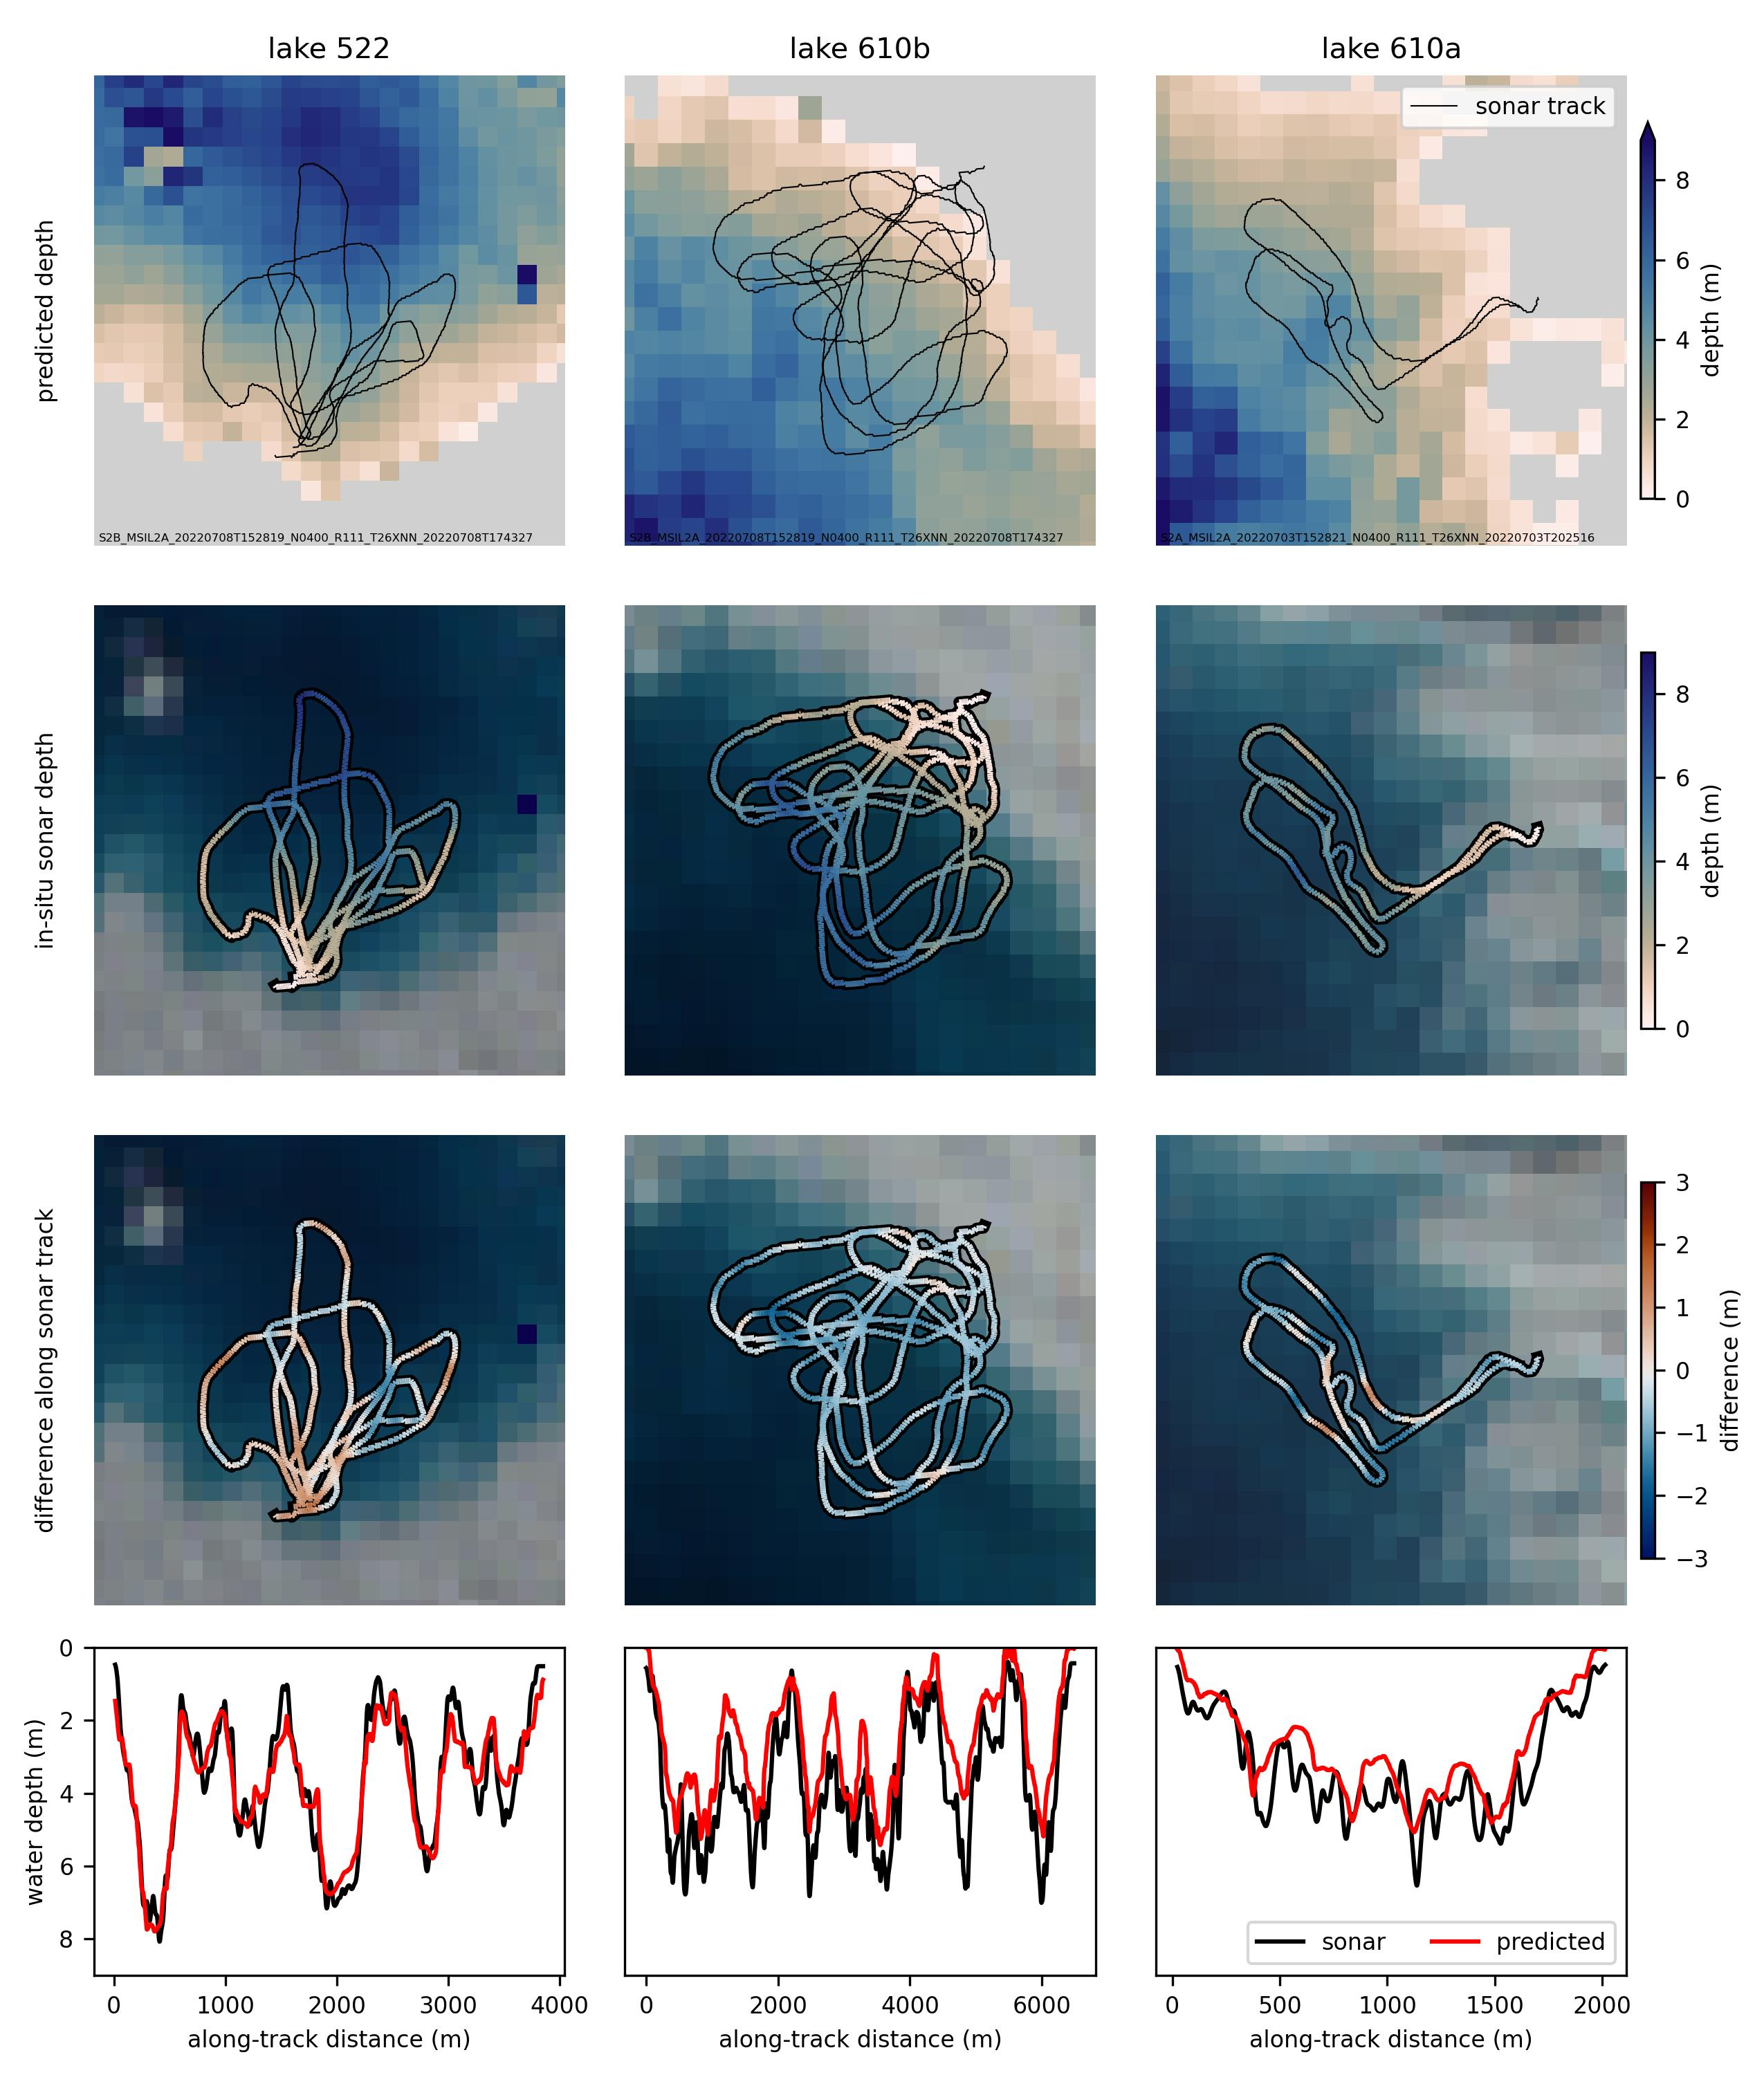

In [23]:
ids = ['lutz_Sonar_2022-07-09_lake522',
       'lutz_Sonar_2022-07-09_lake610b',
       'lutz_Sonar_2022-07-04_lake610a']

plt.rcParams.update({'font.size': 8})

fig = plt.figure(figsize=[8.5,10], dpi=60)
gs = fig.add_gridspec(ncols=3, nrows=11)
axs = []
for i in range(3):
    for j in range(3):
        axs.append(fig.add_subplot(gs[i*3:(i+1)*3, j]))
for i in range(3):
    axs.append(fig.add_subplot(gs[9:, i]))
# for iax, ax in enumerate(axs):
#     ax.text(0.5, 0.5, iax, transform=ax.transAxes, ha='center', va='center')

vmin = 0
vmax = 9
cmap = cmc.lapaz_r
lw_col = 2

for iid, id_sonar in enumerate(ids):
    
    img_fn = 'sonar/sonar_imagery/' + id_sonar.replace('lutz_', '') + '_imagery.tiff'
    img_fn_pred = 'sonar/img_depth_est/' + id_sonar.replace('lutz_', '') + '_depth_pred.tiff'
    myImage = rio.open(img_fn)
    crs_img = myImage.crs
    
    dfs = df_result_valid[df_result_valid.IS2_id == id_sonar]
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(crs_img)
    gdfs[['x_img', 'y_img']] = gdfs.geometry.get_coordinates()

    fac_lims = 0.8
    xr = gdfs.x_img.max() - gdfs.x_img.min()
    yr = gdfs.y_img.max() - gdfs.y_img.min()
    rng = np.max((xr, yr))
    xc = (gdfs.x_img.min() + gdfs.x_img.max()) / 2
    yc = (gdfs.y_img.min() + gdfs.y_img.max()) / 2
    xl_img = (xc - fac_lims*rng, xc + fac_lims*rng)
    yl_img = (yc - fac_lims*rng, yc + fac_lims*rng)

    ax = axs[iid]
    # ax.text(0.5, 0.5, 'full prediction RF here', transform=ax.transAxes, ha='center', va='center')
    img_dat = rio.open(img_fn_pred)
    ib = img_dat.count
    data = img_dat.read(ib)
    extend = 'max' if np.percentile(data, 98) > vmax else 'neither'
    imgp = rioplot.show(data, ax=ax, transform=img_dat.transform, cmap=cmap, vmin=vmin, vmax=vmax)
    data_ = data
    data_[data_ > 0] = np.nan
    rioplot.show(data_, ax=ax, transform=img_dat.transform, cmap=cmc.grayC, vmin=-1, vmax=5)
    if iid == 2:
        cax = ax.inset_axes([1.03, 0.1, 0.03, 0.8])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.nanmin(data), vmax=vmax))
        sm._A = []
        cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend=extend)
        cbar.set_label('depth (m)')
    track_p = ax.plot(gdfs.x_img, gdfs.y_img, 'k-', lw=0.5, label='sonar track')
    ax.axis('off')
    ax.set_xlim(xl_img)
    ax.set_ylim(yl_img)
    ax.set_title(id_sonar.split('_')[-1].replace('lake', 'lake '), fontsize=10)
    ax.text(0.01, 0.01, img_dat.tags(0)['product_id'], transform=ax.transAxes, fontsize=4)
    if iid == 0:
        ax.text(-0.1, 0.5, 'predicted depth', rotation='vertical', transform=ax.transAxes, ha='center', va='center')
    if iid == 2:
        ax.legend(loc='upper right', fontsize=8)

    ax = axs[iid + 3]
    rioplot.show(myImage, ax=ax)
    plot_colorline(x=gdfs.x_img, y=gdfs.y_img, c=gdfs.depth_smooth, cmap=cmap, ax=ax, lw=lw_col, vmin=vmin, vmax=vmax, zorder=11)
    if iid == 2:
        cax = ax.inset_axes([1.03, 0.1, 0.03, 0.8])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.nanmin(data), vmax=vmax))
        sm._A = []
        cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend='neither')
        cbar.set_label('depth (m)')
    ax.plot(gdfs.x_img, gdfs.y_img, 'k-', lw=lw_col*2, zorder=10)
    ax.axis('off')
    ax.set_xlim(xl_img)
    ax.set_ylim(yl_img)
    if iid == 0:
        ax.text(-0.1, 0.5, 'in-situ sonar depth', rotation='vertical', transform=ax.transAxes, ha='center', va='center')

    ax = axs[iid + 6]
    rioplot.show(myImage, ax=ax)
    err_range = np.ceil(np.max(np.abs(dfs.depth_pred - dfs.depth_smooth))) + 1
    cmap_err = cmc.vik
    if iid == 2:
        cax = ax.inset_axes([1.03, 0.1, 0.03, 0.8])
        sm = plt.cm.ScalarMappable(cmap=cmap_err, norm=plt.Normalize(vmin=-err_range, vmax=err_range))
        sm._A = []
        cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend='neither')
        cbar.set_label('difference (m)')
    plot_colorline(x=gdfs.x_img, y=gdfs.y_img, c=gdfs.depth_pred - gdfs.depth_smooth, cmap=cmap_err, ax=ax, lw=lw_col, 
                   vmin=-err_range, vmax=err_range, zorder=11)
    ax.plot(gdfs.x_img, gdfs.y_img, 'k-', lw=lw_col*2, zorder=10)
    ax.axis('off')
    ax.set_xlim(xl_img)
    ax.set_ylim(yl_img)
    if iid == 0:
        ax.text(-0.1, 0.5, 'difference along sonar track', rotation='vertical', transform=ax.transAxes, ha='center', va='center')

    ax = axs[iid + 9]
    p_sonar, = ax.plot(gdfs.xatc, gdfs.depth_smooth, 'k-', label='sonar')
    p_pred, = ax.plot(gdfs.xatc, gdfs.depth_pred, 'r-', label='predicted')
    ax.set_ylim((vmax, vmin))
    ax.set_xlabel('along-track distance (m)')
    if iid == 0:
        ax.set_ylabel('water depth (m)')
    else:
        ax.get_yaxis().set_visible(False)
    if iid == 2:
        ax.legend(loc='lower right', ncols=2, fontsize=8)
    
fig.tight_layout()
figfn = 'plots/fig_validation_sonar.jpg'
fig.savefig(figfn, dpi=300)
plt.close(fig)
display(Image(figfn))

In [ ]:
img_fn_data = img_fn.replace('_imagery.tiff', '_imagery_full_info.tiff')
img_dat = rio.open(img_fn)


In [ ]:
np.max(np.abs(dfs.depth_pred - dfs.depth_smooth))

In [ ]:
img_dat.tags(1)

In [ ]:
with rio.open(img_fn_data) as src:
    # Print the overall metadata of the GeoTIFF
    print("Metadata:")
    print(src.meta)
    print("\n")
    
    # Number of bands
    print(f"Number of bands: {src.count}")
    print("\n")
    
    # Print properties of each band
    for i in range(1, src.count + 1):
        band = src.read(i)
        tags = src.tags(i)
        print(f"band {i}: {tags}")
        print(f" - Data type: {src.dtypes[i-1]}")
        print(f" - Minimum value: {band.min()}")
        print(f" - Maximum value: {band.max()}")
        print(f" - Shape: {band.shape}")
        print("\n")

In [ ]:
img_fn_data

In [ ]:
dfs
gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(crs_img)
gdfs[['x_img', 'y_img']] = gdfs.geometry.get_coordinates()
gdfs

In [ ]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cmcrameri import cm as cmc # scientific colormaps

# for line collection
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# for legend
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerTuple

# Sample data creation (replace this with your actual DataFrame)



# Adding colorbar
cb = fig.colorbar(lc, ax=ax, label='line color')

In [ ]:
################################################################################################################################################
def download_imagery_bbox(image, gdf_img, imgfn_out='auto', imgfn_dir='', axis_aspect=1.0, gamma_value=1.0, scale=5, buffer_image=0.1, re_download=True):

    if (imgfn_dir != '') and (imgfn_dir[-1] != '/'):
        imgfn_dir = imgfn_dir + '/'
        if not os.path.exists(imgfn_dir):
            os.makedirs(imgfn_dir)
    if not (imgfn_out.endswith('.tif') or imgfn_out.endswith('.tiff')):
        if imgfn_out.rfind('.') > 0:
            imgfn = imgfn[:imgfn_out.rfind('.')] + '.tif'
        else:
            imgfn = imgfn + '.tif'
    if imgfn_out == 'auto':
        try:
            imgfn_path = '%s%s.tif' % (imgfn_dir, image.get('PRODUCT_ID').getInfo())
        except:
            imgfn_path = '%ssatellite_image.tif' % imgfn_dir
    else:
        imgfn_path = '%s%s' % (imgfn_dir, imgfn_out)

    if (not re_download) and os.path.isfile(imgfn_path):
        return imgfn_path

    # Points and scale
    lon0, lat0 = gdf_img.lon.iloc[0], gdf_img.lat.iloc[0]
    lon1, lat1 = gdf_img.lon.iloc[-1], gdf_img.lat.iloc[-1]
    loncenter = (lon0 + lon1) / 2
    latcenter = (lat0 + lat1) / 2
    
    crs_local = pyproj.CRS("+proj=stere +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(latcenter, loncenter))
    coordsloc = gdf_img.to_crs(crs_local).get_coordinates()
    dy = coordsloc.y.iloc[-1] - coordsloc.y.iloc[0]
    dx = coordsloc.x.iloc[-1] - coordsloc.x.iloc[0]
    angle_deg = math.degrees(math.atan2(dy, dx))
    
    wkt_crs = '''
    PROJCS["Hotine_Oblique_Mercator_Azimuth_Center",
    GEOGCS["GCS_WGS_1984",
    DATUM["D_unknown",
    SPHEROID["WGS84",6378137,298.257223563]],
    PRIMEM["Greenwich",0],
    UNIT["Degree",0.017453292519943295]],
    PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],
    PARAMETER["latitude_of_center",%s],
    PARAMETER["longitude_of_center",%s],
    PARAMETER["rectified_grid_angle",%s],
    PARAMETER["scale_factor",1],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["m",1.0], 
    AUTHORITY["EPSG","8011112"]]''' % (lat0, lon0, angle_deg)
    
    # get the region of interest from ground track and aspect ratio
    buffer_img_aoi = (gdf_img.xatc.max()-gdf_img.xatc.min()) / axis_aspect / 2 * (1+buffer_image)
    region = ee.Geometry.LineString([[lon0, lat0], [lon1, lat1]]).buffer(buffer_img_aoi)
    
    # stretch the color values 
    def color_stretch(image):
        percentiles = image.select(['B4', 'B3', 'B2']).reduceRegion(**{
            'reducer': ee.Reducer.percentile(**{'percentiles': [1, 99], 'outputNames': ['lower', 'upper']}),
            'geometry': region,
            'scale': 10,
            'maxPixels': 1e9,
            'bestEffort': True
        })
        lower = percentiles.select(['.*_lower']).values().reduce(ee.Reducer.min())
        upper = percentiles.select(['.*_upper']).values().reduce(ee.Reducer.max())
        return image.select(['B4', 'B3', 'B2']).unitScale(lower, upper).clamp(0,1).resample('bilinear').reproject(**{'crs': wkt_crs,'scale': scale})
    
    # stretch color, apply gamma correction, and convert to 8-bit RGB
    rgb_gamma = color_stretch(image).pow(1/gamma_value)
    rgb8bit = rgb_gamma.clamp(0,1).multiply(255).uint8()
    
    # get the download URL and download the selected image
    success = False
    tries = 0
    while (success == False) & (tries <= 10):
        try:
            # Get the download URL
            url = rgb8bit.getDownloadURL({
                'scale': scale,
                'crs': wkt_crs,
                'region': region,
                'format': 'GEO_TIFF',
                'filePerBand': False
            })
            
            # Download the image
            response = requests.get(url)
            with open(imgfn_path, 'wb') as f:
                f.write(response.content)
            if os.path.isfile(imgfn_path):
                success = True
            tries += 1
        except:
            print('-> download unsuccessful, increasing scale to %.1f...' % scale)
            traceback.print_exc()
            scale *= 2
            success = False
            tries += 1
    
    if success:
        return imgfn_path
    else:
        return None

In [ ]:
plt.close('all')
fns = {
    1: 'sonar/data_lutz/Sonar_2022-07-09_lake522.shp',
    2: 'sonar/data_lutz/Sonar_2022-07-04_lake610a.shp',
    3: 'sonar/data_lutz/Sonar_2022-07-09_lake610b.shp'
}
crs_out = 'EPSG:3413'
tformat_in = '%Y-%m-%d %H:%M:%SZ'
tformat_out = '%Y-%m-%dT%H:%M:%SZ'
tformat_print = '%a, %-d %b %Y, %-I:%M %p'

for iax, file in enumerate(list(fns.keys())):

    fn = fns[file]
    gdf = gpd.read_file(fn)
    # gdf['timestamp'] = gdf.apply(lambda x: datetime.timestamp(datetime.strptime(x.Time, tformat_in)), axis=1)
    gdf['timestamp'] = gdf['Time'].apply(lambda x: datetime.strptime(x, tformat_in).replace(tzinfo=timezone.utc).timestamp())
    gdf[['lon', 'lat']] = gdf.geometry.get_coordinates()
    gdf['xatc'] = 0.0
    for i in np.arange(1,len(gdf)):
        gdf.at[i,'xatc'] = gdf.at[i-1,'xatc'] + geodesic(gdf[['lon', 'lat']].iloc[i], gdf[['lon', 'lat']].iloc[i-1]).meters

    date_time_sonar = datetime.strftime(datetime.fromtimestamp(gdf.timestamp.median(), tz=timezone.utc), tformat_out)
    print('\n%s' % fn)
    gdf_sonar = get_S2_along_sonar(gdf, fn=fn, days_buffer=7, min_sun_elevation=20, max_cloudiness=20, 
                                   limit_n_imgs=20, ground_track_buffer=5.0)
    

In [ ]:
# compile all data together
base_dir = 'sonar/sonar_S2_CSVs'

if base_dir[-1] != '/':
    base_dir += '/'
    
searchdir = base_dir
searchfor = '_lakeinfo.csv'
filelist_info = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist_info.sort()
listlength_info = len(filelist_info)
print('number *_lakeinfo.csv:', listlength_info)

searchfor = '.csv'
exclude = '_lakeinfo.csv'
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & (exclude not in f)]
filelist.sort()
listlength = len(filelist)
print('number *.csv:', listlength)

In [ ]:
dfs = []
print('\n\ncompiling data')
for ifn, fn in enumerate(filelist):
    print('%5i / %5i' % (ifn+1, listlength), end='\r')
    dfs.append(pd.read_csv(fn))
df_data = pd.concat(dfs).reset_index(drop=True)

print('\n\n --> done.')

In [ ]:
df_saveinfo = pd.DataFrame({'IS2_id': np.unique(df_data.IS2_id)})
def get_time_sonar(r):
    thisfn = 'sonar/data_lutz/' + r.IS2_id.replace('lutz_Sonar', 'Sonar') + '.shp'
    gdf = gpd.read_file(thisfn)
    gdf['timestamp'] = gdf['Time'].apply(lambda x: datetime.strptime(x, tformat_in).replace(tzinfo=timezone.utc).timestamp())
    date_time_sonar = datetime.strftime(datetime.fromtimestamp(gdf.timestamp.median(), tz=timezone.utc), tformat_out)
    return date_time_sonar
df_saveinfo['time_sonar'] = df_saveinfo.apply(get_time_sonar, axis=1)

# Ignore specific warnings
import scipy
warnings.filterwarnings("ignore", category=scipy.stats.ConstantInputWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in log")
warnings.filterwarnings("ignore", message="All-NaN slice encountered")

df_save = df_data.copy()

# drop unnecessary elevation info from IS2
df_save = df_save.drop(columns=['h_fit_surf', 'h_fit_bed'])

# remove nan data 
print('dropping %d missing values' % df_save.isna().any(axis=1).sum())
df_save = df_save[~df_save.isna().any(axis=1)].reset_index(drop=True)

# cast surface classification to uint8
df_save.SCL = df_save.SCL.astype(np.uint8)

# filter out confidence values lower than 0.05 so nobody grossly abuses data that can't be trusted
conf_thresh = 0.05
df_save = df_save[df_save.conf > conf_thresh]

def norma(x):
    xn = x - np.nanmin(x)
    return xn / np.nanmax(xn)

def check_finite(arr1, arr2):
    return ~(np.isinf(arr1) | np.isnan(arr1) | np.isinf(arr2) | np.isnan(arr2))

def get_matching_stats(col, ndwi_thresh=0.125, min_valid_values=10, conf_thresh=conf_thresh):

    min_fin = min_valid_values
    
    ndwi_match = (col.depth > 0) == (col.ndwi > ndwi_thresh)
    fin = check_finite(col.depth, col.ndwi)
    mat = ndwi_match & fin
    ndwi_match_perc = 0.0 if (np.sum(mat) < min_fin) else ndwi_match.mean() * 100

    ndwi_match_depth = (col.depth > 0) & (col.ndwi > ndwi_thresh)
    is_depth = col.depth > 0
    fin = check_finite(col.depth, col.ndwi)
    mat = ndwi_match_depth & fin
    ndwi_match_perc_depth = 0.0 if (np.sum(mat) < min_fin) else ndwi_match_depth.sum() / is_depth.sum() * 100
    
    ndwi_match_norm = (col.depth > 0) == (norma(col.ndwi) > ndwi_thresh)
    fin = check_finite(col.depth, norma(col.ndwi))
    mat = ndwi_match & fin
    ndwi_match_perc_norm = 0.0 if (np.sum(mat) < min_fin) else ndwi_match_norm.mean() * 100

    ndwi_match_perc_max = np.nanmax((ndwi_match_perc, ndwi_match_perc_norm, 0.0))

    ndwi_match = ndwi_match_depth & (col.conf >= conf_thresh) # use only values where ICESat-2 sees a water depth
    bg_avg = norma(np.mean(np.vstack((norma(np.log(col.B2)), norma(np.log(col.B3)))), axis=0))
    fin = check_finite(col.depth, bg_avg)
    mat = ndwi_match & fin
    Rsquared_log_B2B3 = -1.0 if (np.sum(fin) < min_fin) else pearsonr(-col.depth[fin], bg_avg[fin]).statistic
    Rsquared_log_B2B3_match = -1.0 if (np.sum(mat) < min_fin) else pearsonr(-col.depth[mat], bg_avg[mat]).statistic
    fin = check_finite(col.depth, np.log(col.B2))
    mat = ndwi_match & fin
    Rsquared_log_B2 = -1.0 if (np.sum(fin) < min_fin) else pearsonr(-col.depth[fin], np.log(col.B2)[fin]).statistic
    Rsquared_log_B2_match = -1.0 if (np.sum(mat) < min_fin) else pearsonr(-col.depth[mat], np.log(col.B2)[mat]).statistic
    fin = check_finite(col.depth, np.log(col.B3))
    mat = ndwi_match & fin
    Rsquared_log_B3 = -1.0 if (np.sum(fin) < min_fin) else pearsonr(-col.depth[fin], np.log(col.B3)[fin]).statistic
    Rsquared_log_B3_match = -1.0 if (np.sum(mat) < min_fin) else pearsonr(-col.depth[mat], np.log(col.B3)[mat]).statistic
    fin = check_finite(col.depth, np.log(col.B4))
    mat = ndwi_match & fin
    Rsquared_log_B4 = -1.0 if (np.sum(fin) < min_fin) else pearsonr(-col.depth[fin], np.log(col.B4)[fin]).statistic
    Rsquared_log_B4_match = -1.0 if (np.sum(mat) < min_fin) else pearsonr(-col.depth[mat], np.log(col.B4)[mat]).statistic
    Rsquared_max_full = np.nanmax((Rsquared_log_B2, Rsquared_log_B3, Rsquared_log_B4, Rsquared_log_B2B3, -1.0))
    Rsquared_max_match = np.nanmax((Rsquared_log_B2_match, Rsquared_log_B3_match, Rsquared_log_B4_match, Rsquared_log_B2B3_match, -1.0))
    Rsquared_max = np.nanmax((Rsquared_max_full, Rsquared_max_match, -1.0))

    return pd.Series({
        'ndwi_thresh': ndwi_thresh,
        'ndwi_match_perc': ndwi_match_perc,
        'ndwi_match_perc_norm': ndwi_match_perc_norm,
        'ndwi_match_perc_depth': ndwi_match_perc_depth,
        'ndwi_match_perc_max': ndwi_match_perc_max,
        'Rsquared_log_B2B3': Rsquared_log_B2B3,
        'Rsquared_log_B2B3_match': Rsquared_log_B2B3_match,
        'Rsquared_log_B2': Rsquared_log_B2,
        'Rsquared_log_B2_match': Rsquared_log_B2_match,
        'Rsquared_log_B3': Rsquared_log_B3,
        'Rsquared_log_B3_match': Rsquared_log_B3_match,
        'Rsquared_log_B4': Rsquared_log_B4,
        'Rsquared_log_B4_match': Rsquared_log_B4_match,
        'Rsquared_max_full': Rsquared_max_full,
        'Rsquared_max_match': Rsquared_max_match,
        'Rsquared_max': Rsquared_max,
    })

is2groups = df_save.groupby('IS2_id')
df_info_new = is2groups.apply(get_matching_stats)
df_saveinfo = df_saveinfo.set_index('IS2_id').join(df_info_new)

is_zero_depth = is2groups['depth'].max() == 0.0
not_zero_depth_indices = is_zero_depth[~is_zero_depth].index
not_zero_depth = df_save.apply(lambda x: x.IS2_id in not_zero_depth_indices, axis=1)
df_save = df_save[not_zero_depth].reset_index(drop=True)

# remove any info for lake segments that have been fully removed (just in case)
is2ids = np.unique(df_save.IS2_id)
is_in_data = df_saveinfo.apply(lambda x: x.name in is2ids, axis=1)
df_saveinfo = df_saveinfo[is_in_data]

# sort by estimated ICESat-2 quality
df_save['depth_quality_sort'] = 0.0
df_save = df_save.sort_values(by=['depth_quality_sort', 'IS2_id', 'xatc'], ascending=[False, True, True])

df_saveinfo = df_saveinfo[[
    'time_sonar',
    'ndwi_thresh',
    'ndwi_match_perc',
    'ndwi_match_perc_norm',
    'ndwi_match_perc_depth',
    'ndwi_match_perc_max',
    'Rsquared_log_B2B3',
    'Rsquared_log_B2B3_match',
    'Rsquared_log_B2',
    'Rsquared_log_B2_match',
    'Rsquared_log_B3',
    'Rsquared_log_B3_match',
    'Rsquared_log_B4',
    'Rsquared_log_B4_match',
    'Rsquared_max_full',
    'Rsquared_max_match',
    'Rsquared_max'
]]

df_save = df_save.drop(columns=['depth_quality_sort']).reset_index(drop=True)

In [ ]:
fn_out_info = 'sonar/S2_predictors/sonar_segment_properties.csv'
fn_out_data = 'sonar/S2_predictors/sonar_segments_depth_reflectance_S2.csv'

import pyarrow as pa
fn_out_data_pq = fn_out_data.replace('.csv', '.parquet')
SCHEMA = pa.schema([
    ('lat', pa.float32()),
    ('lon', pa.float32()),
    ('xatc', pa.float32()),
    ('depth', pa.float32()),
    ('conf', pa.float32()),
    ('B1', pa.float32()),
    ('B2', pa.float32()),
    ('B3', pa.float32()),
    ('B4', pa.float32()),
    ('B5', pa.float32()),
    ('B6', pa.float32()),
    ('B7', pa.float32()),
    ('B8', pa.float32()),
    ('B8A', pa.float32()),
    ('B9', pa.float32()),
    ('B11', pa.float32()),
    ('B12', pa.float32()),
    ('AOT', pa.float32()),
    ('WVP', pa.float32()),
    ('SCL', pa.uint8()),
    ('MSK_CLDPRB', pa.float32()),
    ('MSK_SNWPRB', pa.float32()),
    ('cloudScore', pa.float32()),
    ('ndwi', pa.float32()),
    ('SZA', pa.float32()),
    ('SAA', pa.float32()),
    ('VZA_B1', pa.float32()),
    ('VZA_B2', pa.float32()),
    ('VZA_B3', pa.float32()),
    ('VZA_B4', pa.float32()),
    ('VZA_B5', pa.float32()),
    ('VZA_B6', pa.float32()),
    ('VZA_B7', pa.float32()),
    ('VZA_B8', pa.float32()),
    ('VZA_B8A', pa.float32()),
    ('VZA_B9', pa.float32()),
    ('VZA_B11', pa.float32()),
    ('VZA_B12', pa.float32()),
    ('VAA_B1', pa.float32()),
    ('VAA_B2', pa.float32()),
    ('VAA_B3', pa.float32()),
    ('VAA_B4', pa.float32()),
    ('VAA_B5', pa.float32()),
    ('VAA_B6', pa.float32()),
    ('VAA_B7', pa.float32()),
    ('VAA_B8', pa.float32()),
    ('VAA_B8A', pa.float32()),
    ('VAA_B9', pa.float32()),
    ('VAA_B11', pa.float32()),
    ('VAA_B12', pa.float32()),
    ('tdiff_sec', pa.uint32()),
    ('plot_id', pa.uint16()),
    ('S2_id', pa.string()),
    ('IS2_id', pa.string()),
])
df_save.to_parquet(fn_out_data_pq, schema=SCHEMA)
print('\n--> saved file as %s' % fn_out_data_pq)

fn_out_info_pq = fn_out_info.replace('.csv', '.parquet')
df_saveinfo.to_parquet(fn_out_info_pq)
print('\n--> saved file as %s' % fn_out_info_pq)

df_saveinfo.to_csv(fn_out_info)
print('\n--> saved file as %s' % fn_out_info)
df_save.to_csv(fn_out_data, index=False)
print('\n--> saved file as %s' % fn_out_data)

In [ ]:
fn_info = 'sonar/S2_predictors/sonar_segment_properties.parquet'
fn_data = 'sonar/S2_predictors/sonar_segments_depth_reflectance_S2.parquet'
df_info = pd.read_parquet(fn_info)
df_data = pd.read_parquet(fn_data)

In [ ]:
plt.close('all')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['black'])

fig, axs = plt.subplots(nrows=6, ncols=9, figsize=[25,16], dpi=35)
axs = axs.flatten()

for i, k in enumerate(list(df_data)[:-2]):
    ax = axs[i]
    bins = np.arange(-0.5, 11.5) if k == 'SCL' else 30
    ax.hist(df_data[k], bins=bins)
    ax.set_xlabel(k)

while i < (len(axs)-1):
    i+=1
    ax = axs[i]
    ax.axis('off')

supt = 'data distributions'
fig.suptitle(supt + '\n', fontweight='bold')

fig.tight_layout(h_pad=0, w_pad=0)
figfn = 'plots/data_distributions_sonar.jpg'
fig.savefig(figfn, dpi=300)
plt.close(fig)
display(Image(figfn))

In [ ]:
df_in = df_data[['IS2_id', 'lat', 'lon', 'xatc', 'conf', 'depth']].copy()
for i, k in enumerate(list(df_data)[:-2]):

    # log transforms of bands
    if k.startswith('B') or (k=='AOT') or (k=='WVP') or (k=='cloudScore'):
        newname = k+'_log'
        print('%s --> log: %s' % (k, newname))
        log_trans = np.log1p(df_data[k])
        df_in[newname] = log_trans

    # cosines of zenith angles
    if (k=='SZA') or k.startswith('VZA'):
        newname = k+'_cos'
        print('%s --> cos: %s' % (k, newname))
        df_in[newname] = np.cos(np.deg2rad(df_data[k]))
        
    # the features that stay the same
    if k in ['SCL', 'MSK_CLDPRB', 'MSK_SNWPRB', 'ndwi']:
        print('%s --> no change: %s' % (k, k))
        df_in[k] = df_data[k]

    # cosines of relative azimuth angles, and phase angles
    if k.startswith('VAA'):
        bnd = k[4:]
        newname = 'RAA_' + bnd + '_cos'
        print('%s --> cos relative azimuth: %s' % (k, newname))
        RAA = np.cos(np.deg2rad(df_data[k] - df_data.SAA))
        df_in[newname] = RAA
        newname = 'PhA_' + bnd
        print('%s --> phase angle: %s' % (k, newname))
        PhA = np.arccos(np.cos(np.deg2rad(df_data.SZA)) * np.cos(np.deg2rad(df_data['VZA_'+bnd])) + np.sin(np.deg2rad(df_data.SZA)) * np.sin(np.deg2rad(df_data['VZA_'+bnd])) * RAA)
        df_in[newname] = PhA

# visible bands ratios and differences
df_in['ratio_logB4_logB2'] = (df_in.B4_log+1.0) / (df_in.B2_log+1.0)
df_in['ratio_logB4_logB3'] = (df_in.B4_log+1.0) / (df_in.B3_log+1.0)
df_in['ratio_logB3_logB2'] = (df_in.B3_log+1.0) / (df_in.B2_log+1.0)
df_in['diff_logB2_logB4'] = df_in.B2_log - df_in.B4_log
df_in['diff_logB3_logB4'] = df_in.B3_log - df_in.B4_log
df_in['diff_logB2_logB3'] = df_in.B2_log - df_in.B3_log

fn_features = 'sonar/sonar_segments_depth_features.parquet'
df_in.to_parquet(fn_features)
print('\n --> wrote file: %s' % fn_features)
        
df_in

In [ ]:

plt.close('all')


fns = {
    1: 'sonar/Sonar_2022-07-09_lake522.shp',
    2: 'sonar/Sonar_2022-07-04_lake610a.shp',
    3: 'sonar/Sonar_2022-07-09_lake610b.shp'
}

vmin = 0
vmax = 9

# buffers = {
#     1: 2,
#     2: 2,
#     3: 2
# }

buffers = {
    1: 1.2,
    2: 1.5,
    3: 1.5
}

gammas = {
    1: 1.2,
    2: 1.2,
    3: 1.2
}

clouds = {
    1: 50,
    2: 50,
    3: 50
}

crs_out = 'EPSG:3413'
tformat_in = '%Y-%m-%d %H:%M:%SZ'
tformat_out = '%Y-%m-%dT%H:%M:%SZ'
tformat_print = '%a, %-d %b %Y, %-I:%M %p'

# fig, axs = plt.subplots(figsize=[10,9], nrows=2, ncols=3)
# fig, axs = plt.subplots(figsize=[15,10], ncols=3, dpi=60)
fig = plt.figure(figsize=[15,5.8], dpi=60)
gs = fig.add_gridspec(ncols=3, nrows=1)
axs = [fig.add_subplot(gs[0,i]) for i in range(3)]

for iax, file in enumerate(fns.keys()):

    fn = fns[file]
    ax = axs[iax]
    gdf = gpd.read_file(fn)
    gdf['timestamp'] = gdf.apply(lambda x: datetime.timestamp(datetime.strptime(x.Time, tformat_in)), axis=1)
    bbox_gdf = gpd.GeoDataFrame(geometry=[box(*gdf.total_bounds)], crs=gdf.crs, index=[0])
    bbox_gre = bbox_gdf.to_crs(crs_out)
    lonlat = bbox_gdf.geometry.get_coordinates()
    xy = bbox_gre.geometry.get_coordinates()
    buff = buffers[file] * np.max((xy.x.max() - xy.x.min(), xy.y.max() - xy.y.min()))
    bboxbuff = bbox_gre.buffer(buff)
    fn_bbox = fn.replace('sonar/','sonar/bbox_shapefiles/').replace('.shp', '_bbox_buff_%.0f.shp' % buff)
    bboxbuff.to_file(fn_bbox)
    lon_center = lonlat.x.min() + (lonlat.x.max() - lonlat.x.min())/2
    lat_center = lonlat.y.min() + (lonlat.y.max() - lonlat.y.min())/2
    date_time = datetime.strftime(datetime.fromtimestamp(gdf.timestamp.median(), tz=timezone.utc), tformat_out)
    fn_imgry = fn.replace('.shp', '_imagery.tiff')
    print(lon_center, lat_center, date_time, buff)
    fn_imgprops = fn.replace('.shp', '_imgprops.csv')

    # download imagery if needed
    if re_download | (not (os.path.isfile(fn_imgry) and os.path.isfile(fn_imgprops))):
        imgprops = download_S2(lon_center, lat_center, date_time, buffer_m=buff, max_cloud_prob=clouds[file],
                           gamma_value=gammas[file], imagery_filename=fn_imgry, download_imagery=re_download)
        pd.Series(imgprops).to_csv(fn_imgprops, index=False)
    else:
        print('not downloading new imagery')
        imgprops = list(pd.read_csv(fn_imgprops)['0'])

    with rio.open(imgprops[0]) as myImage:
        rioplot.show(myImage, ax=ax)
        ax.axis('off')
        crs_img = myImage.crs
        
    gdf_img = gdf.to_crs(crs_img)
    add_graticule2(gdf=gdf_img, ax_img=ax, meridians_locs=['top'], parallels_locs=['left'], fontsz=6)
    gdf_plot = gdf_img.sort_values(by='Depth')
    gdf_plot[gdf_plot.Depth<0.2].plot(ax=ax, color='gray', markersize=7, edgecolors='none')
    gdf_plot[gdf_plot.Depth>=0.2].plot(ax=ax, column='Depth', cmap=cmc.hawaii, markersize=7, edgecolors='none', vmin=vmin, vmax=vmax)
    gdf_plot.plot(ax=ax, color='k', markersize=0.2, edgecolors='none')
    # sm = plt.cm.ScalarMappable(cmap=cmc.hawaii, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # sm._A = []
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='3%', pad=0.05)
    # cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    # cbar.set_label('sonar water depth (m)')
    
    lake_id = fn.split('_')[-1].replace('.shp','').replace('lake', 'lake ')
    datetime_plot = datetime.strftime(datetime.fromtimestamp(gdf.timestamp.median(), tz=timezone.utc), tformat_print)
    datetime_print_s2 = datetime.strftime(datetime.strptime(imgprops[1],tformat_out), tformat_print)
    lon_str = '%.4f°%s' % (np.abs(lon_center), 'W' if lon_center < 0 else 'E')
    lat_str = '%.4f°%s' % (np.abs(lat_center), 'S' if lon_center < 0 else 'N')

    # get the proper time difference
    t_s2 = datetime.strptime(imgprops[1], tformat_out).replace(tzinfo=timezone.utc)
    t_sonar = datetime.fromtimestamp(gdf.timestamp.median(), tz=timezone.utc)
    tdiff = t_s2 - t_sonar
    tsec = tdiff.total_seconds()
    sign = 'before' if np.sign(tsec) < 0 else 'after'
    tsec = np.abs(tsec) 
    days, rem = divmod(tsec, 24 * 60 * 60)
    hrs, rem = divmod(rem, 60 * 60)
    mins, secs = divmod(rem, 60)
    days = '' if days == 0 else '%i days, ' % days
    hrs = '' if hrs == 0 else '%i hrs, ' % hrs
    mins = '%i mins' % mins
    tdiff_str = 'imagery %s%s%s %s sonar' % (days,hrs,mins,sign)
    
    txt = '%s, %s | %s UTC' % (lat_str, lon_str, datetime_plot)
    tbbox = dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1.7)
    tbx = ax.text(0.5, 0.92, lake_id, transform=ax.transAxes, ha='center', va='bottom',fontsize=14)
    tbx.set_bbox(tbbox)
    tbx = ax.text(0.5, 0.9, txt, transform=ax.transAxes, ha='center', va='top',fontsize=8)
    tbx.set_bbox(tbbox)
    
    ## add some info about the Sentinel-2 image
    txt = 'sonar data: Katrina Lutz et al.'
    txt += '\nimagery: Sentinel-2, %s UTC\n' % datetime_print_s2
    txt += '- %s\n' % imgprops[4]
    txt += '- mean cloud probability: %.1f%%\n' % float(imgprops[3])
    txt += 'time difference: %s' % tdiff_str
    tbx = ax.text(0.01, 0.01, txt, transform=ax.transAxes, ha='left', va='bottom',fontsize=5)
    tbbox = dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.5)
    tbx.set_bbox(tbbox)

    print('\n%s' % lake_id)
    print('location: %.5f, %.5f' % (lon_center, lat_center))
    print('time:', datetime_plot)
    print('n_obs', len(gdf_plot[gdf_plot.Depth>0]))
    print('depth_max', gdf_plot.Depth.max())
    print('depth_min', gdf_plot.Depth.min())
    print('depth_min_nonzero %.2f\n' % gdf_plot[gdf_plot.Depth>0].Depth.min())

ax_full = fig.add_subplot(gs[0,:])
ax_full.axis('off')
cax = ax_full.inset_axes([0, 0.06, 1, 0.025])
sm = plt.cm.ScalarMappable(cmap=cmc.hawaii, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('sonar water depth (m)')
# cbar.set_label('photon signal\nconfidence', fontsize=8, labelpad=1.5)
# cax.tick_params(axis='both', which='major', labelsize=7)

# axs[-1].axis('off')
fig.tight_layout()
figname = 'supraglacial_lakes_sonar_depth_GrIS_NE.jpg'
fig.savefig(figname, dpi=600)
plt.close(fig)
display(Image(figname))